<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/46_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. ВВОДНАЯ ЧАСТЬ


- ТЕМА: Оптимизация YOLO для детекции объектов на мобильных устройствах.

- АВТОР: Высочанский М.В.

- НАПРАВЛЕНИЕ: Сравнение производительности YOLO с другими моделями детекции объектов на мобильных устройствах. Исследование моделей Yolo для достижения максимальной производительности и точности. Методы оптимизаци.

### 2. Теоретическая часть

### Описание работы с мобильным устройством
- В качестве мобильного устройства будет иcпользоваться одноплатный компьютер Raspberry Pi 5 Model B Rev 1.0

- Для работы с устройством будет использован метод удаленного подключения через SSH


In [ ]:
# Учитывая требования NDA часть информации будет скрыта
%%bash
sudo apt install wireguard          # Установка VPN-протокола WireGuard
sudo wg-quick up air-control        # Запуск VPN-протокола WireGuard
ssh pi@10.66.66.@@@                 # Подключение к устройству по SSH
ip route                            # Проверка доступности устройства
sudo apt-get install python3-venv   # Установка пакета для виртуального окружения
python3 -m venv env                 # Создаем виртуальное окружения
source env/bin/activate             # Активируем виртуальное окружение

### 3. УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
# Установка необходимых библиотек в виртуальное окружение
%%capture
!pip install ipywidgets
!pip install ultralytics
!pip install torch
!pip install torchvision
!pip install opencv-python

In [ ]:
# Импотрируем необходимые библиотеки
import cv2
import numpy as np
from ultralytics import YOLO
import time

### 4. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ YOLO v8 nano

- Для работы на мобильных устройствах (без GPU) будет использоваться экспорт модели в INT8 и OpenVINO.

In [ ]:
# Функция для экспорта модели в INT8 формат OpenVINO
def export_int8_model():
    model = YOLO('yolov8n.pt')
    model.export(format='openvino', int8=True, imgsz=640, data='coco.yaml')

model = YOLO('yolov8n_openvino_model/', task='detect')

- ВНИМАНИЕ!!!
Для захвата изображения с web-камеры и трансляции его в Colab требуется писать скрипт на языке JS. Текущий скрипт адаптирован под работу на мобильных устройствах.

In [ ]:
# Захват с web-камеры
cap = cv2.VideoCapture(0)   # НЕРАБОТАЕТ В COLAB!!!

# Переменные для расчета FPS
frame_count = 0
start_time = time.time()
avg_fps = 0

- Главный цикл для реализации детекции с захваченного видеопотока

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Замер времени обработки
    inference_start = time.time()

    # Детекция
    results = model(frame, imgsz=640, verbose=False, half=False)

    # Расчет FPS
    # inference_time = time.time() - inference_start
    frame_count += 1

    # Обновление FPS
    if frame_count % 20 == 0:
        end_time = time.time()
        fps = frame_count / (end_time - start_time)
        print(f"FPS: {fps:.2f}")
        frame_count = 0
        start_time = time.time()

        # Отрисовка результатов
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()

            for box, conf, cls in zip(boxes, confs, classes):
                if cls == 0 and conf > 0.7:  # Класс 0 = 'person', порог уверенности поставил 70%
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    print((x1, y1), (x2, y2))
                cv2.putText(frame, f'Person {conf:.3f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    # Показ результата
    cv2.imshow('YOLOv8', frame)

    # Выход по нажатию на 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

### 5. ОЦЕНКА РЕЗУЛЬТАТОВ

- Для первичных анализов результатов выведем изображение на экран.
- Оценим точность детекции и FPS

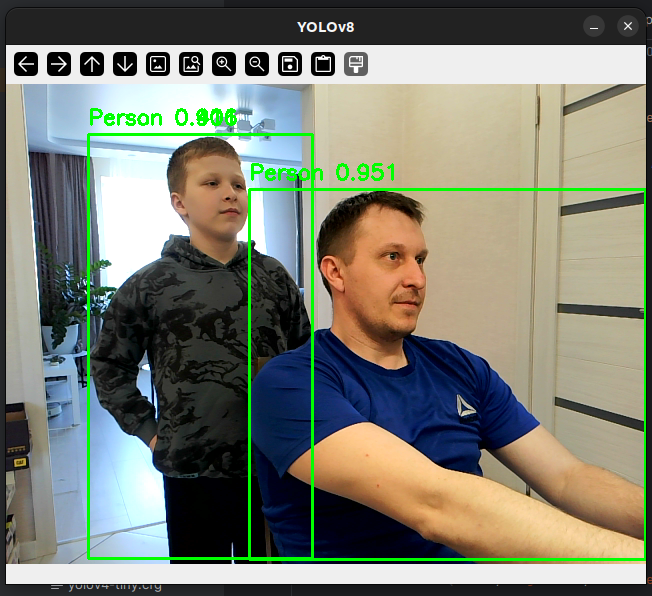

In [ ]:
# Вывод изображения с web-камеры
from IPython.display import Image, display
display(Image('screen1.png'))

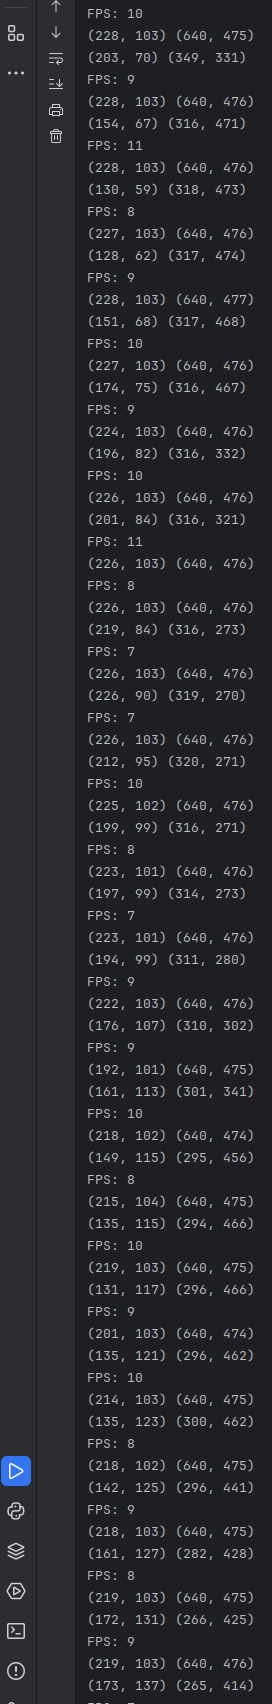

In [ ]:
# Оценим производительность и наличие контуров объектов
display(Image('screen2.png'))

- Вывод: модель yolov8n обладает высоким качеством детекции, но низкой скоростью обработки. Это не подходит для работы на мобильных устройствах.

### 6. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ YOLO v5 nano

In [ ]:
# Импотрируем необходимые библиотеки
import cv2
import torch
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Инициализация устройства и загрузка модели
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)
model.conf = 0.25       # Порог уверенности для детекции
model.classes=[0]       # Осталяем только один класс - 'person'

In [ ]:
# Применение оптимизаций - на случай запуска скрипта с GPU
model = model.to(device)
if device == 'cuda':
    model = model.half()  # Используем FP16 на GPU
else:
    model = model.float()  # Используем FP32 на CPU

In [ ]:
# Открытие видеопотока
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Ошибка открытия видеопотока")
    exit()

In [ ]:
# Параметры обработки изображения
input_size = 320         # Уменьшение разрешения изображения
prev_time = time.time()

- Главный цикл для реализации детекции с захваченного видеопотока

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Предобработка кадра
    frame_resized = cv2.resize(frame, (input_size, input_size))
    img_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

    # Инференс
    start_time = time.time()
    results = model(img_rgb, size=input_size)
    inference_time = 1 / (time.time() - start_time)

    # Вывод результатов детекции
    detections = results.pandas().xyxy[0]
    for _, det in detections.iterrows():
        print(f"КЛАСС: {det['name']:15} УВЕРЕННОСТЬ: {det['confidence']:.2f} | "
                  f"КОНТУРЫ: {det['xmin']:.1f}, {det['ymin']:.1f}, {det['xmax']:.1f}, {det['ymax']:.1f}")

    # Вывод статистики производительности
    print(f"Текущий FPS: {round(inference_time)}")
    print("-" * 80)

# Высвобождение ресурсов
cap.release()
cv2.destroyAllWindows()

### 7. ОЦЕНКА РЕЗУЛЬТАТОВ

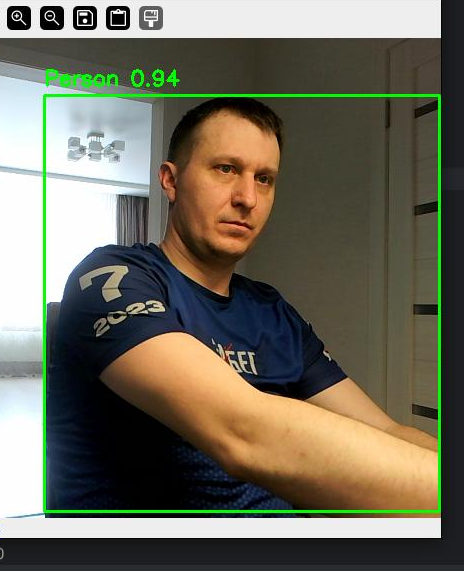

In [ ]:
# Вывод изображения с web-камеры
display(Image('screen4.png'))

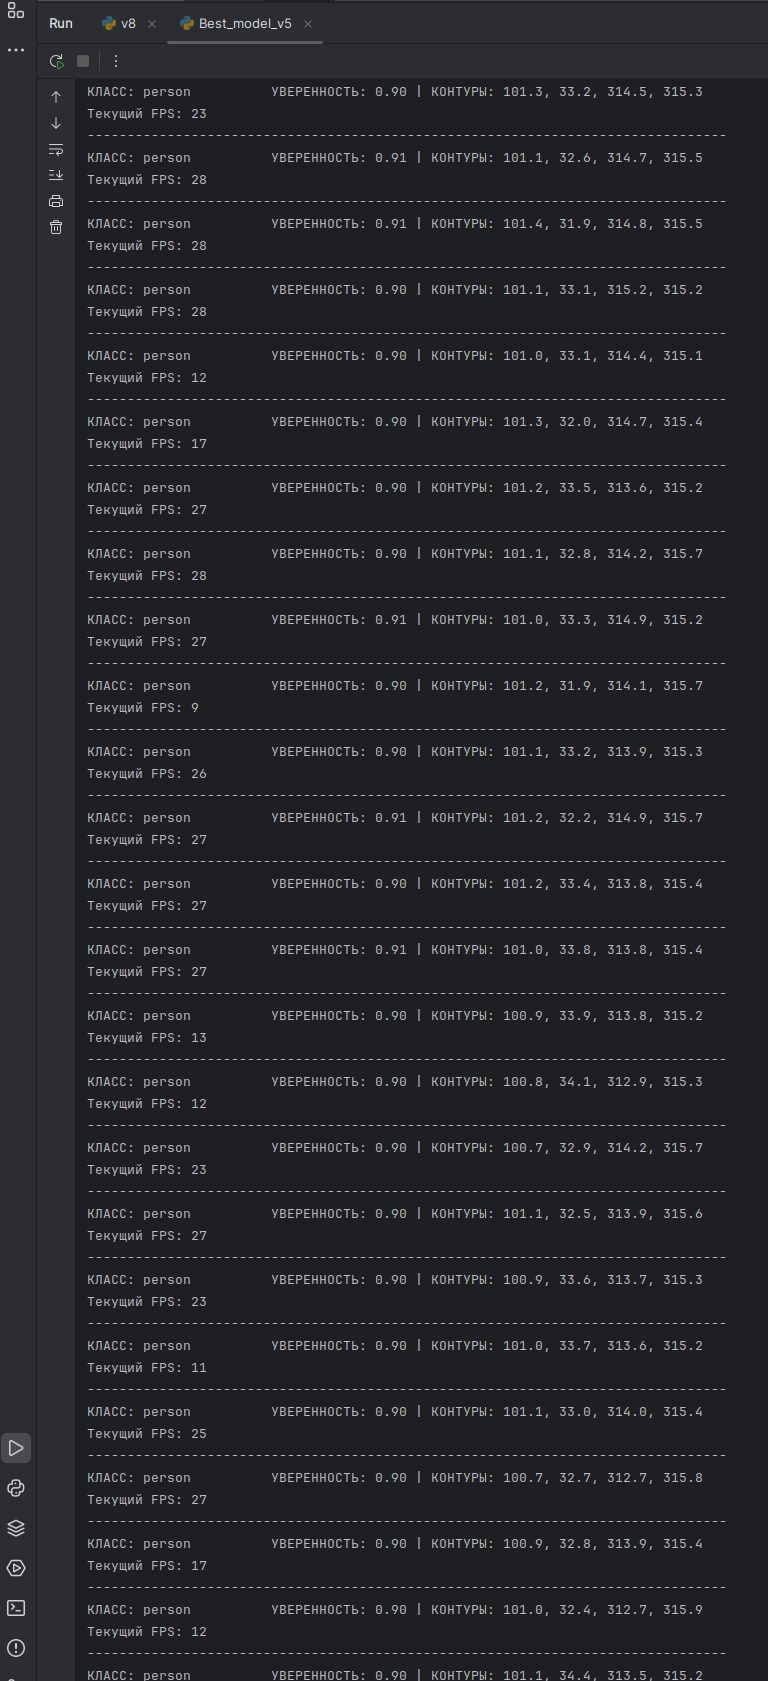

In [ ]:
# Оценим производительность и наличие контуров объектов
display(Image('screen3.png'))

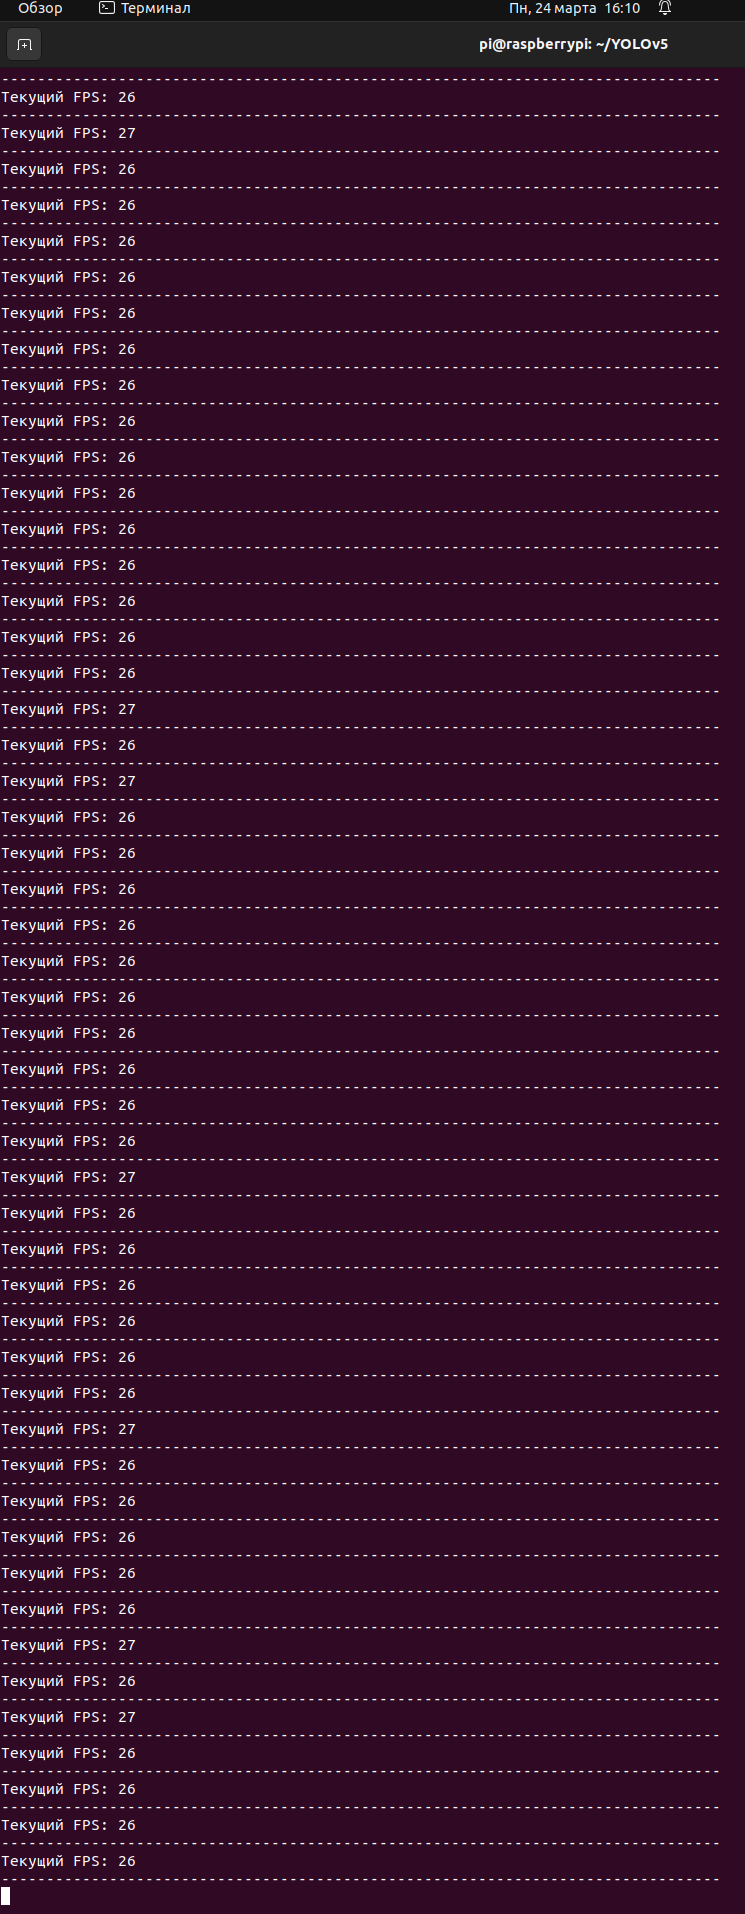

In [ ]:
# Запустим код на Raspberry Pi и оценим производительность на мобильном устройстве
display(Image('screen5.png'))

- Теперь уменьшим вдвое размер изображения и оценим производительность

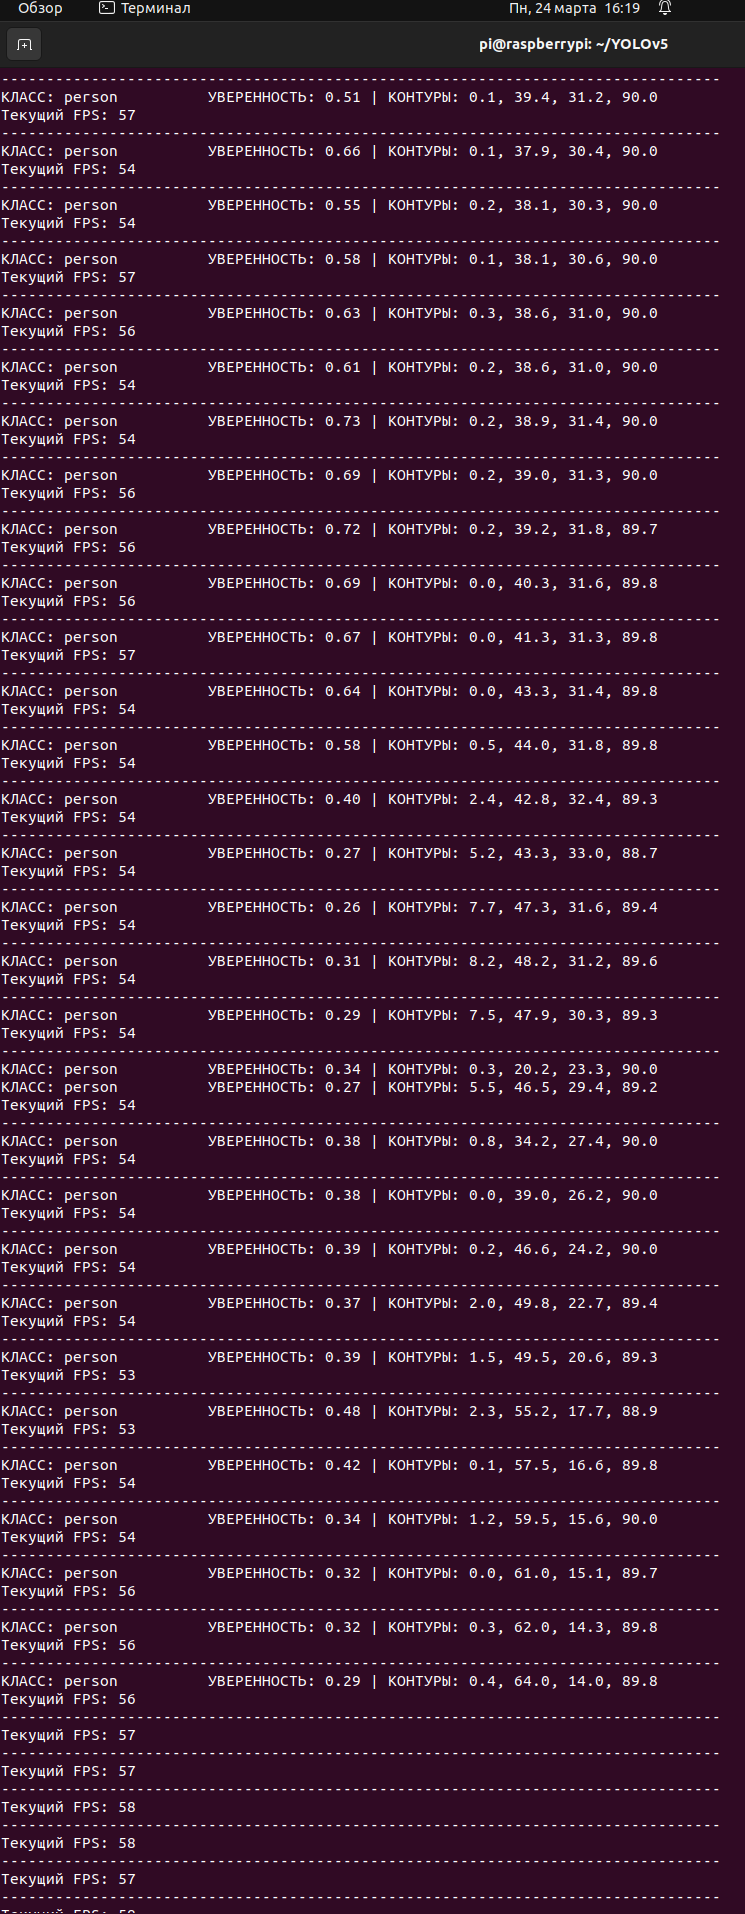

In [ ]:
input_size = 180
display(Image('screen6.png'))

- Очевидно, что с небольшой потерей confidence мы получили прирост в FPS

### 7. РАБОТА YOLO В COLAB

- Принимая во внимание, что захват видео с web-камеры пользователя и вывод видеопотока в Colab требует написание кода в JS, напишем скрипт для корректной работы

In [ ]:
import cv2
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from ultralytics import YOLO
import os
from google.colab.patches import cv2_imshow
from google.colab import files

# Установка зависимостей
!pip install ultralytics opencv-python-headless

# Функция обработки видео с YOLOv8
def process_video(input_path):
    model = YOLO('yolov8n.pt')

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Ошибка: Не удалось открыть видеофайл")
        return

    frame_count = 0
    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Детекция объектов
        results = model(frame)
        annotated_frame = results[0].plot()

        # Расчет FPS
        frame_count += 1
        fps = frame_count / (time.time() - start_time)
        cv2.putText(annotated_frame, f"FPS: {fps:.2f}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Отображение результата
        cv2_imshow(annotated_frame)
        clear_output(wait=True)

        # Задержка для плавного воспроизведения
        time.sleep(5)

    cap.release()
    print("Обработка видео завершена!")

# Функция загрузки видео
def upload_and_process():
    print("Пожалуйста, загрузите ваше видео (формат mp4):")
    uploaded = files.upload()

    if not uploaded:
        print("Видео не загружено. Пожалуйста, попробуйте снова.")
        return

    for filename in uploaded.keys():
        video_path = filename
        print(f"\nНачинаем обработку видео: {filename}")
        process_video(video_path)
        return

# Создаем кнопку
upload_button = widgets.Button(
    description='Загрузить и обработать видео',
    button_style='success',
    layout=widgets.Layout(width='250px', height='50px')
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        clear_output()
        upload_and_process()

upload_button.on_click(on_button_click)

# Отображаем интерфейс
display(HTML("<h3>Детекция объектов с YOLOv8</h3>"))
display(upload_button)
display(output_area)

Button(button_style='success', description='Загрузить и обработать видео', layout=Layout(height='50px', width=…

Output()

### 8. ВЫВОДЫ

- Существуют модели Yolo спсобные работать на мобильных устройствах, без GPU.
- Чем старше модель, тем медленнее она обрабатывает данные, доже с применением квантования.
- Уменьшие разрешения,кантование из int32 в int16/int8, сокращение классов для детекции и запуск посредствам ONNX Runtime дает прирост производительности.